# Разработка модели предсказывающий коэффициент восстановления золота из золотосодержащей руды
**Проект №8 (сборный проект - 2) Яндекс.Практикум - Data Science**

## Описание проекта

**Исходные данные:**

Сырые данные технологического процесса (данные с параметрами добычи и очистки) по получение полезных ископаемых из руды.

**Цель проекта:**

Построить модель предсказывающий коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Условия задачи:**

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

<img alt="image" class="image image_expandable"  width="80%" height="80%" src="https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg">

Стадии очистки:
1. Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Структура проекта
* [1. Подготовка данных](#start)
* [2. Анализ данных](#eda)
    * [2.1 Концентрация металлов (Au, Ag, Pb) на различных этапах очистки](#concentrate)
        * [Au - золото](#concentrate_au)
        * [Ag - серебро](#concentrate_ag)
        * [Pb - свинец](#concentrate_pb)
    * [2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#feed_size)
    * [2.3 Суммарная концентрация всех веществ на разных стадиях](#sum)
* [3. Построение модели](#model)
    * [3.1 Функция для вычисления метрики sMAPE](#smape)
    * [3.2 Обучение и выбор модели](#fit)
    * [3.3 Проверка модели на тестовой выборке](#test)
* [4. Общий вывод](#conclusion)

<a id="start"></a>
## 1. Подготовка данных

#### Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import clear_output

In [2]:
# input path of datasets
PATH = input()

../datasets/


In [3]:
dataset_name_full  = 'gold_recovery_full.csv'
dataset_name_train = 'gold_recovery_train.csv'
dataset_name_test  = 'gold_recovery_test.csv'

try:
    data_full = pd.read_csv(f'{PATH}{dataset_name_full}', sep=',')
    print(f'Прочитан файл с данными: "{PATH}{dataset_name_full}"')
    data_train = pd.read_csv(f'{PATH}{dataset_name_train}', sep=',')
    print(f'Прочитан файл с данными: "{PATH}{dataset_name_train}"')
    data_test = pd.read_csv(f'{PATH}{dataset_name_test}', sep=',')
    print(f'Прочитан файл с данными: "{PATH}{dataset_name_test}"')
except:
    print(repr(err))

Прочитан файл с данными: "../datasets/gold_recovery_full.csv"
Прочитан файл с данными: "../datasets/gold_recovery_train.csv"
Прочитан файл с данными: "../datasets/gold_recovery_test.csv"


In [4]:
pd.set_option('display.max_columns', None) # display all columns

In [5]:
data_full.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [6]:
data_train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [7]:
data_test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

#### Проверим есть ли у нас пропуски в данных

In [8]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [10]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Небольшое количество пропусков имеется по многим признакам

#### Описание данных

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков**

[этап].[тип_параметра].[название_параметра]

**Возможные значения для блока [этап]:**
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики
* Возможные значения для блока [тип_параметра]:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

**Установим дату как индекс**

In [12]:
data_full.set_index('date', inplace=True)
data_train.set_index('date', inplace=True)
data_test.set_index('date', inplace=True)

**Проверим, что эффективность обогащения рассчитана правильно.**

Вычислим её на обучающей выборке для признака rougher.output.recovery.

In [13]:
def recovery(C, F, T):
    '''Returns recovery value in percents.'''
    return ((C * (F - T)) / (F * (C - T))) * 100

Перед расчётом МАЕ удалим пропущенные значения в столбце 'final.output.recovery' (не меняя исходный датасет)

In [14]:
data_train_mae = data_train[~data_train['final.output.recovery'].isna()]

In [15]:
au_recovery = recovery(data_train_mae['final.output.concentrate_au'], data_train_mae['rougher.input.feed_au'], data_train_mae['final.output.tail_au'])
data_train_mae['final.output.recovery'] - au_recovery

date
2016-01-15 00:00:00    0.000000e+00
2016-01-15 01:00:00    0.000000e+00
2016-01-15 02:00:00    4.263256e-14
2016-01-15 03:00:00    1.421085e-14
2016-01-15 04:00:00    0.000000e+00
                           ...     
2018-08-18 06:59:59    0.000000e+00
2018-08-18 07:59:59   -1.421085e-14
2018-08-18 08:59:59    0.000000e+00
2018-08-18 09:59:59    0.000000e+00
2018-08-18 10:59:59    1.421085e-14
Length: 15339, dtype: float64

In [16]:
print(f"MAE: {mean_absolute_error(data_train_mae['final.output.recovery'], au_recovery)}")

MAE: 7.981398137240443e-15


Результаты нашего вычисления и данных в выборке соответствуют с точностью до погрешности вычисления чисел с плавающей точкой.

**Учтём, что по времени данные очень близки и заменим пропуски предыдущим значением**

In [17]:
def clear_nan(data):
    if data.isna().sum() == 0:
        return
    for i in range(1,len(data)):
        if np.isnan(data.iloc[i]):
            data.iloc[i] = data.iloc[i-1]
    if data.isna().sum() !=0:
        raise RuntimeError(f"Something goes wrong! {data.isna().sum()} values haven't fixed!")

In [18]:
datas = [data_train, data_full]
for data, i in zip(datas, range(len(datas))):
    iterate_columns = data.columns.tolist()
    if 'rougher.output.recovery' in iterate_columns:
        iterate_columns.remove('rougher.output.recovery')
    if 'final.output.recovery' in iterate_columns:
        iterate_columns.remove('final.output.recovery')
    for clmn, j in zip(iterate_columns, range(len(iterate_columns))):
        clear_nan(data[clmn])
        clear_output(wait=True)
        print(f'{(((j+1)/len(iterate_columns))/(len(datas)-i))*100:.0f}% done')
        
print('Calculating has finished')

100% done
Calculating has finished


**Обработаем пропуски в столбце 'final.output.recovery'**

In [19]:
missed_count_before = data_train['rougher.output.recovery'].isna().sum()
data_train['rougher.output.recovery'] = recovery(data_train['rougher.output.concentrate_au'], data_train['rougher.input.feed_au'], data_train['rougher.output.tail_au'])
print(f"Заменили {missed_count_before - data_train['rougher.output.recovery'].isna().sum():4d} значений в столбце эффективности обогащения на рассчитанные на этапе флотации")

missed_count_before = data_train['final.output.recovery'].isna().sum()
print(f"Заменили {missed_count_before - data_train['final.output.recovery'].isna().sum():4d} значений в столбце эффективности обогащения на рассчитанные на этапе очистки")
data_train['final.output.recovery'] = recovery(data_train['final.output.concentrate_au'], data_train['rougher.input.feed_au'], data_train['final.output.tail_au'])

Заменили 1404 значений в столбце эффективности обогащения на рассчитанные на этапе флотации
Заменили    0 значений в столбце эффективности обогащения на рассчитанные на этапе очистки


Удалим строки с оставшимися пропусками

In [20]:
before = data_train.shape[0]
for clmn in data_train.columns:
    data_train = data_train[~data_train[clmn].isna()]
print(f'{before - data_train.shape[0]} of all {before} or {((before - data_train.shape[0])/before)*100:.2f}% has deleted')

1285 of all 16860 or 7.62% has deleted


In [21]:
before = data_test.shape[0]
for clmn in data_test.columns:
    data_test = data_test[~data_test[clmn].isna()]
print(f'{before - data_test.shape[0]} of all {before} or {((before - data_test.shape[0])/before)*100:.2f}% has deleted')

473 of all 5856 or 8.08% has deleted


In [22]:
before = data_full.shape[0]
for clmn in data_full.columns:
    data_full = data_full[~data_full[clmn].isna()]
print(f'{before - data_full.shape[0]} of all {before} or {((before - data_full.shape[0])/before)*100:.2f}% has deleted')

3277 of all 22716 or 14.43% has deleted


Удалим получившиеся бесконечности при расчёте эффективности обогащения

In [23]:
data_train = data_train.replace([np.inf, -np.inf], np.nan)

before = data_train.shape[0]
for clmn in data_train.columns:
    data_train = data_train[~data_train[clmn].isna()]
print(f'{before - data_train.shape[0]} of all {before} or {((before - data_train.shape[0])/before)*100:.2f}% has deleted')

Deleted 34 of all 15575 or 0.22%


**Проанализируем признаки которых нет в тестовой выборке**

In [24]:
columns_absent_in_train = list(set(data_train.columns) - set(data_test.columns))
data_train.loc[:,sorted(columns_absent_in_train)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 15541 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         15541 non-null  float64
 1   final.output.concentrate_au                         15541 non-null  float64
 2   final.output.concentrate_pb                         15541 non-null  float64
 3   final.output.concentrate_sol                        15541 non-null  float64
 4   final.output.recovery                               15541 non-null  float64
 5   final.output.tail_ag                                15541 non-null  float64
 6   final.output.tail_au                                15541 non-null  float64
 7   final.output.tail_pb                                15541 non-null  float64
 8   final.output.tail_sol                            

Можем сделать вывод, что у нас в тестовой выборке отсутствуют данные по содержанию полезных ископаемых на всех этапах очистки руды в концентрате и в отвальных хвостах.

### Вывод
* Обнаруженные пропуски в данных обработали (рассчитали из имеющихся данных или удалили)
* Проверили что в обучающей выборке эффективность обогащения посчитана верно
* Обнаружено, что в тестовой выборки отсутствуют данные по концетрации полезных ископаемых на всех этапах обработки руды

<a id="eda"></a>
## 2. Анализ данных

<a id="concentrate"></a>
### 2.1 Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Посмотрим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [25]:
ag_concentrate_columns = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
au_concentrate_columns = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
pb_concentrate_columns = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

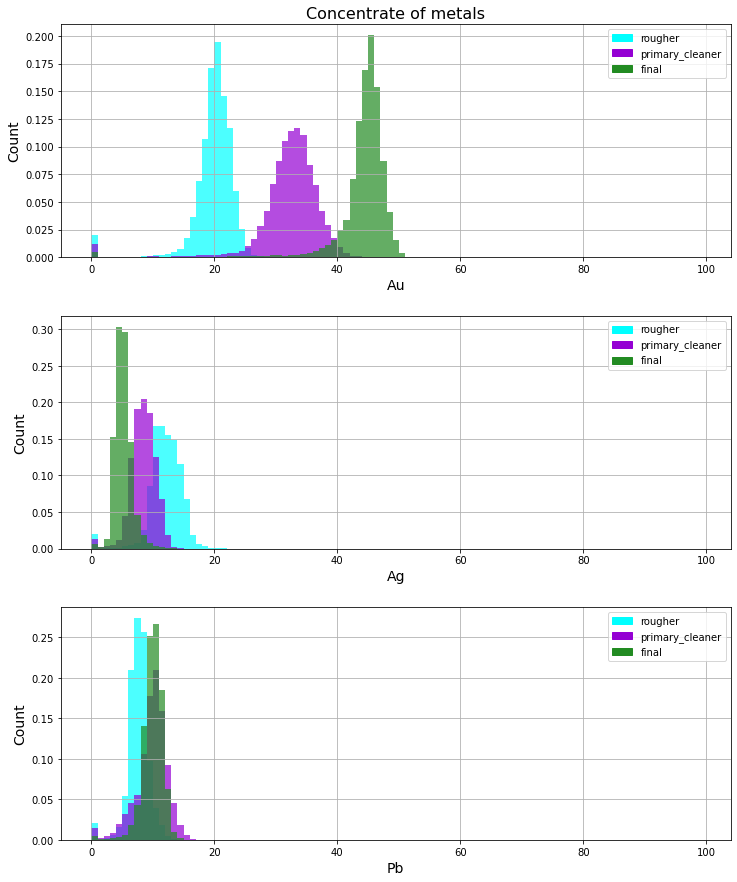

In [27]:
alpha = 0.7
bins  = range(100)
colors = ['aqua', 'darkviolet', 'forestgreen']

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(12, 15)
ax[0].set_title(f"Concentrate of metals", fontsize=16)

patches = []
for clmn, color in zip(au_concentrate_columns, colors):
    ax[0].hist(data_full[clmn], density=True, color=color, bins=bins, alpha=alpha)
    patches.append(mpatches.Patch(color=color, label=clmn.split('.')[0]))
ax[0].grid(True)
ax[0].set_xlabel(f"Au", fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].legend(handles=patches, loc='upper right')

for clmn, color in zip(ag_concentrate_columns, colors):
    ax[1].hist(data_full[clmn], density=True, color=color, bins=bins, alpha=alpha)
ax[1].grid(True)
ax[1].set_xlabel(f"Ag", fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)
ax[1].legend(handles=patches, loc='upper right')

for clmn, color in zip(pb_concentrate_columns, colors):
    ax[2].hist(data_full[clmn], density=True, color=color, bins=bins, alpha=alpha)
ax[2].grid(True)
ax[2].set_xlabel(f"Pb", fontsize=14)
ax[2].set_ylabel('Count', fontsize=14)
ax[2].legend(handles=patches, loc='upper right')

plt.subplots_adjust(hspace=0.25)
plt.show()

Заметим выбросы в виде нулевых значений концентрации на различных этапах.

<a id="concentrate_au"></a>
#### Au - золото

In [28]:
data_full.loc[:,au_concentrate_columns].describe()

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19439.000000,19439.000000,19439.000000
mean,19.772000,32.119400,44.076513
std,3.753600,5.627611,5.129784
min,0.000000,0.000000,0.000000
25%,18.802523,30.463140,43.402215
50%,20.280214,32.841295,45.011244
75%,21.717843,35.048006,46.275313
max,28.824507,45.933934,52.756638


<a id="concentrate_ag"></a>
#### Ag - серебро

In [29]:
data_full.loc[:,ag_concentrate_columns].describe()

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,19439.000000,19439.000000,19439.000000
mean,11.994759,8.442408,5.168387
std,2.733862,2.054465,1.372362
min,0.000000,0.000000,0.000000
25%,10.628337,7.263288,4.251000
50%,12.098115,8.507298,5.066039
75%,13.736996,9.809001,5.895401
max,24.480271,16.081632,16.001945


<a id="concentrate_pb"></a>
#### Pb - свинец

In [30]:
data_full.loc[:,pb_concentrate_columns].describe()

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,19439.000000,19439.000000,19439.000000
mean,7.606272,9.799976,9.978821
std,1.796757,2.593366,1.669228
min,0.000000,0.000000,0.000000
25%,6.725987,8.671652,9.137225
50%,7.742580,10.140198,10.102264
75%,8.565199,11.416016,11.035644
max,13.617072,17.081278,17.031899


### Вывод
* На каждом этапе очистки повышается доля содержания золота в руде
* Доля серебра на каждом этапе немного уменьшается
* Доля свинца после первого этапа очистки немного увеличивается, на втором этапе очистки почти не изменяется

<a id="feed_size"></a>
### 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

In [31]:
feed_sizes = [ 'rougher.input.feed_size', 'primary_cleaner.input.feed_size']

**Размеры гранул сырья на обучающей выборке**

In [32]:
data_train.loc[:,feed_sizes].describe()

,rougher.input.feed_size,primary_cleaner.input.feed_size
count,15541.000000,15541.000000
mean,60.608697,7.302850
std,26.774241,0.610915
min,9.659576,1.080000
25%,48.278238,6.930000
50%,54.933824,7.280000
75%,66.107290,7.670000
max,484.967466,10.470000


**Размеры гранул сырья на тестовой выборке**

In [33]:
data_test.loc[:,feed_sizes].describe()

,rougher.input.feed_size,primary_cleaner.input.feed_size
count,5383.000000,5383.000000
mean,56.338644,7.268670
std,21.836788,0.610441
min,0.046369,5.650000
25%,43.913766,6.892500
50%,50.924232,7.250000
75%,62.364984,7.600000
max,477.445473,15.500000


**Построим график распределения размеров гранул**

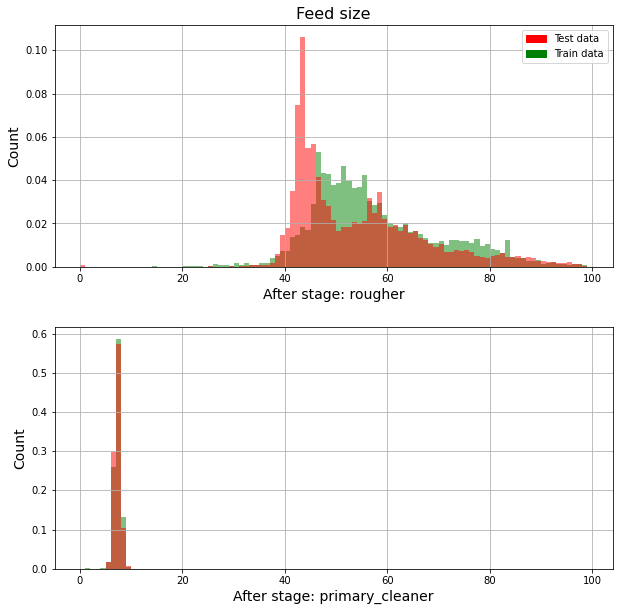

In [41]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 10)
ax[0].set_title(f"Feed size", fontsize=16)
green_patch = mpatches.Patch(color='green', label='Train data')
red_patch = mpatches.Patch(color='red', label='Test data')
ax[0].legend(handles=[red_patch, green_patch])

for i, clmn in zip(range(len(feed_sizes)), feed_sizes):
    ax[i].hist(data_train[clmn], bins=range(100), density=True, color='g', alpha=0.5)
    ax[i].hist(data_test[clmn], bins=range(100), density=True, color='r', alpha=0.5)
    ax[i].grid(True)
    ax[i].set_xlabel(f"After stage: {clmn.split('.')[0]}", fontsize=14)
    ax[i].set_ylabel('Count', fontsize=14)

plt.subplots_adjust(hspace=0.25)
plt.show()

### Вывод
* Существенных отличий гранул сырья в обучающей и тестовой выборе не выявлено, но на графике распределения размеров гранул после флотации мы видим, что на тестовой выборке при средних значениях размеров гранул наблюдается аномально малое количество данных, что может повлиять на оценку качества модели на тестовой выборке.
* Для более глубокого анализа необходимо провести проверку гипотезы об отличии гранул сырья

<a id="sum"></a>
### 2.3 Суммарная концентрация всех веществ на разных стадиях

In [35]:
def plot_sum_concentrate_hist(data=None, columns=None, bins=None):
    '''Plot histogram of sum of selected columns.'''
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10, 4)
    
    ax.set_title(f"Concentrate of all minerals on stage: {columns[0].split('.')[0]}", fontsize=16)
    ax.hist(data[columns].sum(axis=1), bins=range(bins), color='forestgreen')
    ax.grid(True)
    ax.set_xlabel("Sum of minerals concentrate", fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

    plt.subplots_adjust(hspace=0.25)
    plt.show()

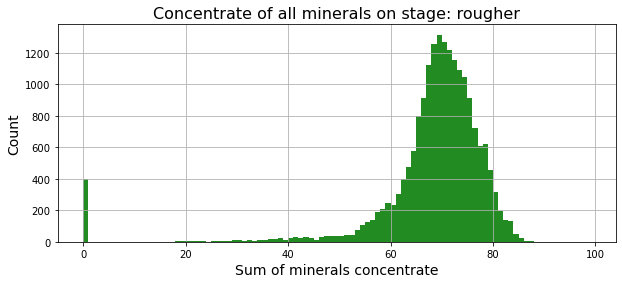

In [36]:
all_mineralls_concentrate_columns_rougher = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
plot_sum_concentrate_hist(data_full, all_mineralls_concentrate_columns_rougher, 100)

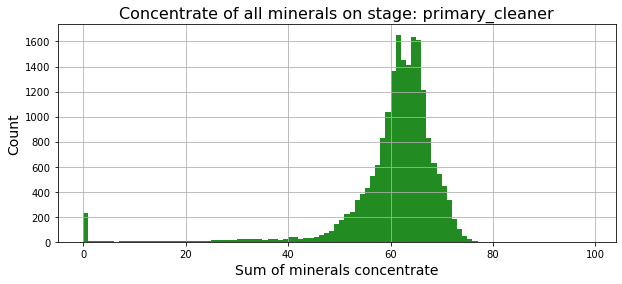

In [37]:
all_mineralls_concentrate_columns_primary_cleaner = ['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol']
plot_sum_concentrate_hist(data_full, all_mineralls_concentrate_columns_primary_cleaner, 100)

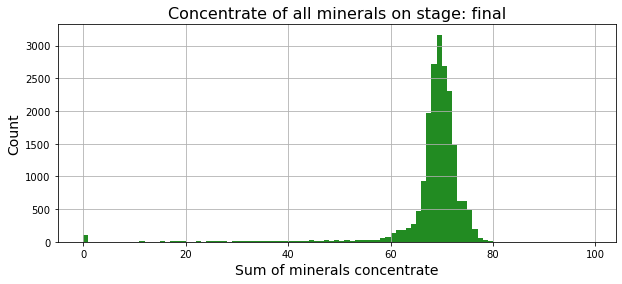

In [38]:
all_mineralls_concentrate_columns_final = ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol']
plot_sum_concentrate_hist(data_full, all_mineralls_concentrate_columns_final, 100)

Мы не знаем причин появления нулевых значений концентрации полезных ископаемых, поэтому, чтобы не подавать на обучение модели эти данные, то мы от них избавимся. Возможными причинами наличия нулевых значений является поломка измерительного оборудования или сбои в записи информации.

In [40]:
print(f'Удалим {data_train.loc[data_train[all_mineralls_concentrate_columns_rougher].sum(axis=1) < 0.1].shape[0]:3d} строк из обучающей выборки с нулевыми значениями концетрации на этапе флотации')
data_train = data_train.loc[data_train[all_mineralls_concentrate_columns_rougher].sum(axis=1) > 0.1]
print(f'Удалим {data_train.loc[data_train[all_mineralls_concentrate_columns_primary_cleaner].sum(axis=1) < 0.1].shape[0]:3d} строк из обучающей выборки с нулевыми значениями концетрации на этапе первичной очистки')
data_train = data_train.loc[data_train[all_mineralls_concentrate_columns_primary_cleaner].sum(axis=1) > 0.1]
print(f'Удалим {data_train.loc[data_train[all_mineralls_concentrate_columns_final].sum(axis=1) < 0.1].shape[0]:3d} строк из обучающей выборки с нулевыми значениями концетрации на этапе вторичной очистки')
data_train = data_train.loc[data_train[all_mineralls_concentrate_columns_final].sum(axis=1) > 0.1]

Удалим   0 строк из обучающей выборки с нулевыми значениями концетрации на этапе флотации
Удалим   0 строк из обучающей выборки с нулевыми значениями концетрации на этапе первичной очистки
Удалим   0 строк из обучающей выборки с нулевыми значениями концетрации на этапе вторичной очистки


Из тестовой выборки мы нулевые значения не удаляем.

### Вывод
* Удалили строки с нулевыми значениями концентрации полезных ископаемых

<a id="model"></a>
## 3. Построение модели

<a id="smape"></a>
### 3.1 Функция для вычисления метрики sMAPE

In [42]:
def smape(y, y_pred):
    '''Returns sMAPE in percents'''
    return ((sum((abs(y - y_pred)) / ((abs(y) + abs(y_pred)) / 2))) / len(y)) * 100

def smape_rougher_final(y, y_pred):
    '''Returns full sMAPE in percents of rougher and final recovery'''
    if(y.shape[0] != y_pred.shape[0]):
        raise ValueError(f'Found input variables with inconsistent numbers of samples: [{y.shape[0]}, {y_pred.shape[0]}]')
    else:
        y_pred_df = pd.DataFrame(y_pred, index=y.index, columns=y.columns) # 2D nparray to DataFrame
        smape_rougher = smape(y['rougher.output.recovery'], y_pred_df['rougher.output.recovery'])
        smape_final = smape(y['final.output.recovery'], y_pred_df['final.output.recovery'])
        return 0.25*smape_rougher + 0.75*smape_final

<a id="fit"></a>
### 3.2 Обучение и выбор модели

In [48]:
SEED = 91
CV_FOLDS = 5

**Разделим тренировочную выборку на признаки и целевые признаки**

In [43]:
features_train = data_train[data_test.columns.tolist()]
target_train = data_train[['rougher.output.recovery','final.output.recovery']]

**Используем как модель предсказание среднего значения**

In [44]:
# dummy regressor
predicted_train_dummy = pd.DataFrame([target_train.mean()], index=target_train.index)
smape_dummy = smape_rougher_final(target_train, predicted_train_dummy)
print(f'sMAPE на моделе предсказывающей среднее значение: {smape_dummy}')

sMAPE на моделе предсказывающей среднее значение: 46.773775413003534


**Линейная регрессия**

In [45]:
model = LinearRegression(copy_X=True, n_jobs=-1)
scaler = StandardScaler()
features_train_transformed = scaler.fit_transform(features_train)
model.fit(features_train_transformed, target_train)

predicted_train = model.predict(features_train_transformed)
smape_train_linear = smape_rougher_final(target_train, predicted_train)

print('sMAPE на линейной регрессии:', smape_train_linear)

sMAPE на линейной регрессии: 122.26475657665674


**Random Forrest**

In [46]:
scorer = make_scorer(smape_rougher_final, greater_is_better=False)

model_rfr = RandomForestRegressor(random_state=SEED, n_jobs=7)
scaler = StandardScaler()
features_train_transformed = scaler.fit_transform(features_train)
parameters = {'n_estimators':[100, 150, 200], 'max_depth':range(8,12,2), 'min_samples_leaf':range(5,20,5)}
clf = GridSearchCV(model_rfr, parameters, cv=CV_FOLDS, scoring=scorer)
clf.fit(features_train_transformed, target_train)

print(f'Лучшие параметры модели: {clf.best_estimator_}')
print(f'Лучший результат sMAPE: {-clf.best_score_}')

Лучшие параметры модели: RandomForestRegressor(max_depth=8, min_samples_leaf=15, n_estimators=150,
                      n_jobs=7, random_state=91)
Лучший результат sMAPE: -11.426956601901022


### Вывод
* Методом кросс-валидации нашли лучшую модель случайного леса и сравнили полученные значения sMAPE при использовании среднего значения и модели линейной регрессии

<a id="test"></a>
### 3.3 Проверка модели на тестовой выборке

Получим недостающие столбцы в тестовой выборке из полного датасета и посчитаем значение sMAPE на тестовой выборке

In [47]:
features_test= data_test.loc[data_test.index.intersection(data_full.index)]
target_test = data_full.loc[data_test.index.intersection(data_full.index), ['rougher.output.recovery','final.output.recovery']]

features_test_transformed = scaler.transform(features_test)

predicted_test= clf.predict(features_test_transformed)
smape_test = smape_rougher_final(target_test, predicted_test)

print('sMAPE:', smape_test)

sMAPE: 10.920205574273673


<a id="conclusion"></a>
## 4. Общий вывод
**Подготовили и проанализировали данные. Выявленные пропуски в данных по возможности заменили предыдущим значением по времени исходя из предположения, что значения близкие по времени не должны сильно отличаться. Выявленные аномалии в виде нулевых значений удалили из тренировочной выборки. Выбрали наилучшую модель модель предсказания значения recovery по метрике sMAPE, применив метод кросс-валидации, и проверили полученную модель на тестовой выборке. Получили итоговое значение sMAPE = 11.**

**Данную модель можно использовать для предсказания эффективности восстановления золота из золотосодержащей руды.**

**Рекомендуется проверять значения на выбросы и аномальность перед подачей на модель предсказания.**